# MuJoCo Physics Simulation 

### This notebook's purpose is to demostrate how Google Deepmind's Mujoco library can be used for physical modeling and simulation for Reinforcement Learning. We will also be utilizing OpenAI's gymnasium environment.

#### Install libraries

In [1]:
import numpy as np
import pygame
import gymnasium as gym
from gymnasium import utils
import mujoco
from gymnasium import spaces
import mediapy as media
import os

pygame 2.5.2 (SDL 2.28.3, Python 3.8.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


#### Packages for platting and visualization

In [2]:
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List
import matplotlib.pyplot as plt

#### MJCF model of a simple arm

In [3]:
xml = """
<mujoco>
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.01"/>
  <worldbody>
    <!-- <camera name="view_camera" pos="0 0 2" mode="targetbody" target="reacher"/> -->
    <!-- <light name="top" pos="0 0 1"/> -->
    <body name="reacher" pos="0 0 0">
       <!-- <joint name="base_slider" type="slide" pos="0 0 0" range="-1 1" limited="true" axis="0 1 0"/> -->
       <!-- <geom name="base" pos="0 0 0" size="0.05" rgba="1 0 0 1"/> -->
      <body name="shoulder_to_elbow" pos="0 0 0">
        <joint name="joint0" type="hinge" pos="0 0 0" axis="0 0 1" />
        <geom fromto="0 0 0 0.5 0 0" name="link0" rgba="0.0 0.4 0.6 1" size=".04" type="capsule"/>
        <geom name="green_sphere" pos="0.5 0 0" size=".05" rgba="0 1 0 1"/>
        <body name="elbow_to_tip" pos="0.51 0 0">
            <joint name="joint1" type="hinge" pos="0 0 0" axis="0 0 1" />
            <geom fromto="0 0 0 0.5 0 0" name="link1" rgba="0.0 0.4 0.6 1" size=".04" type="capsule"/>
            <geom name="tip" pos="0.5 0 0" size=".05" rgba="0 1 0 1"/>
        </body>
      </body>
      
    </body>
    <body name="target" pos=".1 -.1 .01">
			<joint armature="0" axis="1 0 0" damping="0" limited="true" name="target_x" pos="0 0 0" range="-.27 .27" ref=".1" stiffness="0" type="slide"/>
			<joint armature="0" axis="0 1 0" damping="0" limited="true" name="target_y" pos="0 0 0" range="-.27 .27" ref="-.1" stiffness="0" type="slide"/>
			<geom conaffinity="0" contype="0" name="target" pos="0 0 0" rgba="0.9 0.2 0.2 1" size=".009" type="sphere"/>
		</body>
  </worldbody>
  <!-- <actuator>
        Actuators for Arm Joints
        <motor ctrllimited="true" ctrlrange="-0.05 0.05" gear="100.0" joint="joint0"/>
        <motor ctrllimited="true" ctrlrange="-0.05 0.05" gear="100.0" joint="joint1"/>
        <motor ctrllimited="true" ctrlrange="-0.1 0.1" gear="100.0" joint="base_slider"/>
    </actuator> -->

</mujoco>


"""

In [4]:
model = mujoco.MjModel.from_xml_string(xml)

#### Basig info about the model

In [5]:
model.ngeom

5

In [6]:
model.geom_rgba

array([[0. , 0.4, 0.6, 1. ],
       [0. , 1. , 0. , 1. ],
       [0. , 0.4, 0.6, 1. ],
       [0. , 1. , 0. , 1. ],
       [0.9, 0.2, 0.2, 1. ]], dtype=float32)

In [7]:
[model.geom(i).name for i in range(model.ngeom)]

['link0', 'green_sphere', 'link1', 'tip', 'target']

#### mjData contains the state and quantities that depend on it. The state is made up of time, generalized positions and generalized velocities. These are respectively data.time, data.qpos and data.qvel.

In [8]:
data =  mujoco.MjData(model)
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [9]:
mujoco.mj_kinematics(model, data)
print(data.geom_xpos)

[[ 0.25  0.    0.  ]
 [ 0.5   0.    0.  ]
 [ 0.76  0.    0.  ]
 [ 1.01  0.    0.  ]
 [ 0.1  -0.1   0.01]]


#### Renderer

""

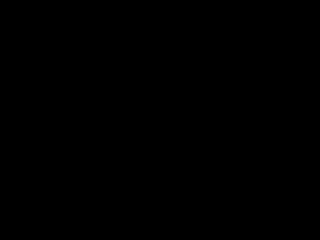

In [10]:
renderer= mujoco.Renderer(model)
media.show_image(renderer.render())

#### The above is black because we need to propogate tge values in mjData. We do this by calling mj_forward

""

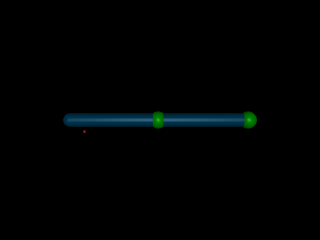

In [11]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

""

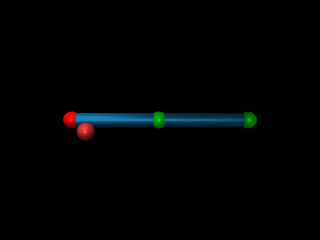

In [12]:
xml = """
<mujoco>
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.01"/>
  <worldbody>
    <!-- <camera name="view_camera" pos="0 0 2" mode="targetbody" target="reacher"/> -->
    <light name="top" pos="0 0 1"/>
    <body name="reacher" pos="0 0 0">
       <!-- <joint name="base_slider" type="slide" pos="0 0 0" range="-1 1" limited="true" axis="0 1 0"/> -->
       <!-- <geom name="base" pos="0 0 0" size="0.05" rgba="1 0 0 1"/> -->
      <body name="shoulder_to_elbow" pos="0 0 0">
        <joint name="joint0" type="hinge" pos="0 0 0" axis="0 0 1" />
        <geom fromto="0 0 0 0.5 0 0" name="link0" rgba="0.0 0.4 0.6 1" size=".04" type="capsule"/>
        <geom name="green_sphere" pos="0.5 0 0" size=".05" rgba="0 1 0 1"/>
        <body name="elbow_to_tip" pos="0.51 0 0">
            <joint name="joint1" type="hinge" pos="0 0 0" axis="0 0 1" />
            <geom fromto="0 0 0 0.5 0 0" name="link1" rgba="0.0 0.4 0.6 1" size=".04" type="capsule"/>
            <geom name="tip" pos="0.5 0 0" size=".05" rgba="0 1 0 1"/>
        </body>
      </body>
      
    </body>
    <body name="target" pos=".1 -.1 .01">
			<joint armature="0" axis="1 0 0" damping="0" limited="true" name="target_x" pos="0 0 0" range="-.27 .27" ref=".1" stiffness="0" type="slide"/>
			<joint armature="0" axis="0 1 0" damping="0" limited="true" name="target_y" pos="0 0 0" range="-.27 .27" ref="-.1" stiffness="0" type="slide"/>
			<geom conaffinity="0" contype="0" name="target" pos="0 0 0" rgba="0.9 0.2 0.2 1" size=".009" type="sphere"/>
		</body>
  </worldbody>
  <!-- <actuator>
        Actuators for Arm Joints
        <motor ctrllimited="true" ctrlrange="-0.05 0.05" gear="100.0" joint="joint0"/>
        <motor ctrllimited="true" ctrlrange="-0.05 0.05" gear="100.0" joint="joint1"/>
        <motor ctrllimited="true" ctrlrange="-0.1 0.1" gear="100.0" joint="base_slider"/>
    </actuator> -->

</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

#### Simulation

In [13]:
clip_length = 5 #length of the video clip in seconds
fps = 60 # Frames per second

frames = []
mujoco.mj_resetData(model, data) # reset state and time

while data.time < clip_length:
    mujoco.mj_step(model, data)
    if(len(frames)<fps*clip_length):
        #update scene before getting this frame's pixel values
        renderer.update_scene(data) #We only need 'data' because this represents the state. 'model' is constant and does not change
        frame_pixel_vals = renderer.render()
        frames.append(frame_pixel_vals)

media.show_video(frames, fps=fps)

#### Enable joint visualization

In [14]:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

In [18]:
xml = """
<mujoco>
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.01"/>
  <worldbody>
    <camera name="view_camera" pos="0 0 2" mode="targetbody" target="reacher"/>
    <light name="top" pos="0 0 1"/>
    <body name="reacher" pos="0 0 0">
       <joint name="base_slider" type="slide" pos="0 0 0" range="-2 2" limited="true" axis="-1 0 0"/>
       <geom name="base" pos="0 0 0" size="0.05" rgba="1 0 0 1"/>
      <body name="shoulder_to_elbow" pos="0 0 0">
        <joint name="joint0" type="hinge" pos="0 0 0" axis="0 1 0" />
        <geom fromto="0 0 0 0.5 0 0" name="link0" rgba="0.0 0.4 0.6 1" size=".04" type="capsule"/>
        <geom name="green_sphere" pos="0.5 0 0" size=".05" rgba="0 1 0 1"/>
        <body name="elbow_to_tip" pos="0.51 0 0">
            <joint name="joint1" type="hinge" pos="0 0 0" axis="0 1 0" />
            <geom fromto="0 0 0 0.5 0 0" name="link1" rgba="0.0 0.4 0.6 1" size=".04" type="capsule"/>
            <geom name="tip" pos="0.5 0 0" size=".05" rgba="0 1 0 1"/>
        </body>
      </body>
      
    </body>
    <body name="target" pos=".1 -.1 .01">
			<joint armature="0" axis="1 0 0" damping="0" limited="true" name="target_x" pos="0 0 0" range="-1 1" ref=".1" stiffness="0" type="slide"/>
			<joint armature="0" axis="0 0 1" damping="0" limited="true" name="target_y" pos="0 0 0" range="-1 1" ref="-.1" stiffness="0" type="slide"/>
			<geom conaffinity="0" contype="0" name="target" pos="0 0 0" rgba="0.9 0.2 0.2 1" size=".05" type="sphere"/>
		</body>
  </worldbody>
  <actuator>
        <!-- Actuators for Arm Joints -->
        <motor ctrllimited="true" ctrlrange="-0.2 0.2" gear="100.0" joint="joint0"/>
        <motor ctrllimited="true" ctrlrange="-0.2 0.2" gear="100.0" joint="joint1"/>
        <motor ctrllimited="true" ctrlrange="-0.2 0.2" gear="100.0" joint="base_slider"/>
  </actuator>

</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)

In [19]:

frames.clear() #Clear out the frames so that we can save the new frames

mujoco.mj_resetData(model, data)
while data.time < clip_length:
    mujoco.mj_step(model, data)
    if(len(frames)<fps*clip_length):
        renderer.update_scene(data, scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=fps)

#### See our model in the mujoco interactive viewer

In [17]:
import mujoco.viewer
mujoco.viewer.launch(model=model)